# Code 1 - Set up

### Target:
- Get the set-up right
- Set Transforms
- Set Data Loader
- Set Basic Working Code
- Set Basic Training & Test Loop

### Results:
- Parameters: 6.3M
- Best Training Accuracy: 99.85
- Best Test Accuracy: 99.06

### Analysis:
- Extremely Heavy Model for such a problem
- Model is over-fitting, 
- Basic data augmentations is done
- Need to change model in next step

In [1]:
import sys
#Check the working mode
'google.colab' in sys.modules

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7']


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1325,), (0.3105,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/home/shiv-nlp-mldl-cv/anaconda3/envs/S6-VSCode/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


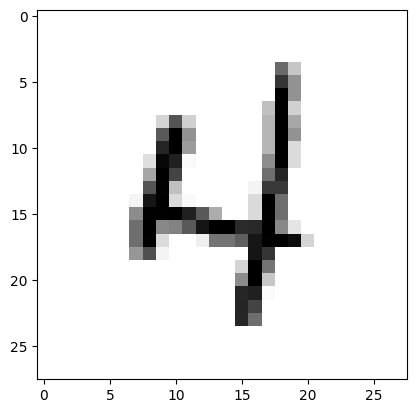

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

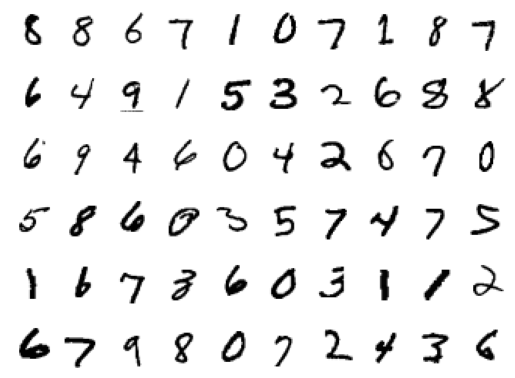

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [10]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [7]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)
exp_data = exp.test_data
exp_data = exp.transform(exp_data.numpy())

print('[Test]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


/home/shiv-nlp-mldl-cv/anaconda3/envs/S6-VSCode/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/shiv-nlp-mldl-cv/anaconda3/envs/S6-VSCode/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# The model
Let's start with the model we first saw

In [12]:
from models import Model1 as Net ,get_summary

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [14]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [15]:
model =  Net(dropout_value=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,None)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

EPOCH: 0


Loss=0.04961332678794861 Batch_id=468 Accuracy=88.05: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]



Test set: Average loss: 0.0629, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.021601667627692223 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]



Test set: Average loss: 0.0354, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.054414842277765274 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]



Test set: Average loss: 0.0322, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.005524927284568548 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]



Test set: Average loss: 0.0295, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.008749961853027344 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]



Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.003462654771283269 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]



Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.03697783127427101 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.01703360117971897 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]



Test set: Average loss: 0.0281, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.004866370931267738 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.00039030585321597755 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0258, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.00030494536622427404 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]



Test set: Average loss: 0.0344, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.0011902058031409979 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]



Test set: Average loss: 0.0302, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.0001085176772903651 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]



Test set: Average loss: 0.0276, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.00032154982909560204 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0336, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=4.979278401151532e-06 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.0278, Accuracy: 9928/10000 (99.28%)



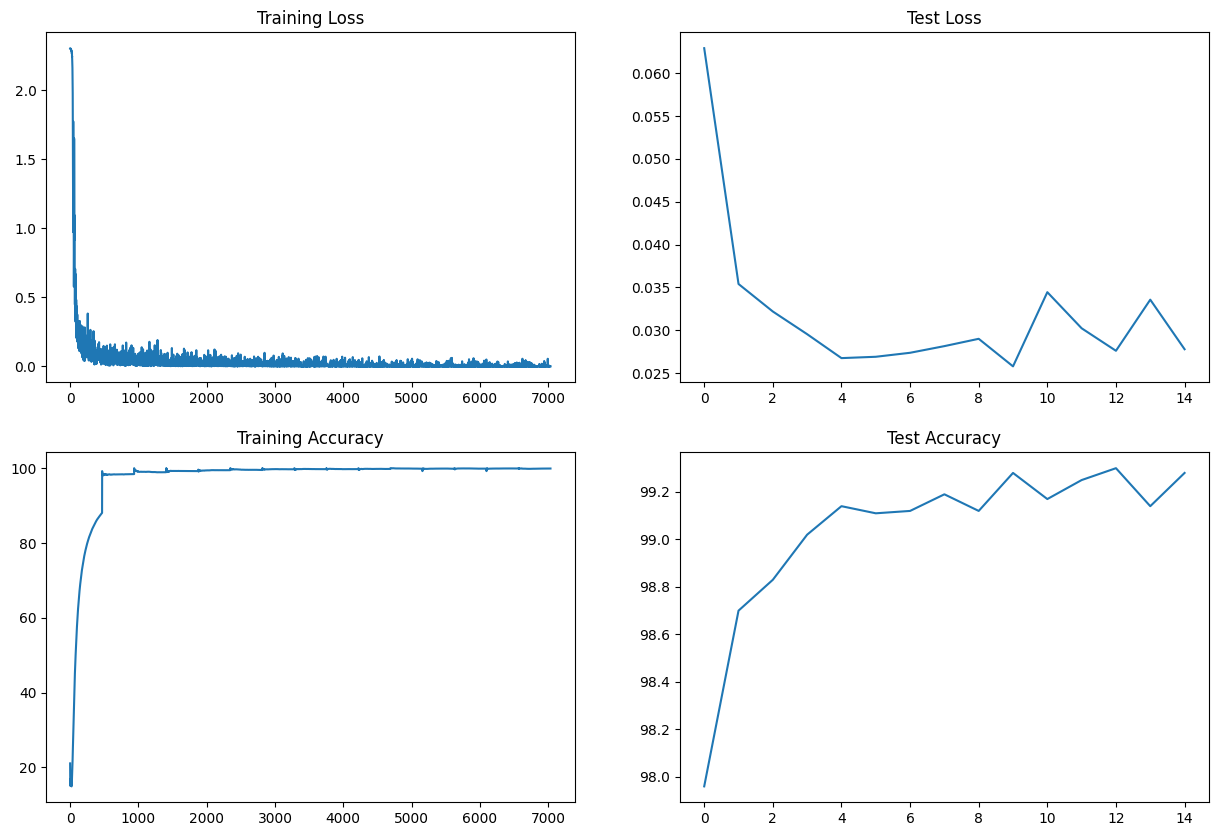

In [18]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)